<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Important-notes" data-toc-modified-id="Important-notes-1">Important notes</a></span></li><li><span><a href="#0-Extract-relevant-data" data-toc-modified-id="0-Extract-relevant-data-2">0 Extract relevant data</a></span></li><li><span><a href="#Part-1" data-toc-modified-id="Part-1-3">Part 1</a></span><ul class="toc-item"><li><span><a href="#1.1-Data-visualization" data-toc-modified-id="1.1-Data-visualization-3.1">1.1 Data visualization</a></span></li><li><span><a href="#1.2-Fourier-descriptors-(15-pts)" data-toc-modified-id="1.2-Fourier-descriptors-(15-pts)-3.2">1.2 Fourier descriptors (15 pts)</a></span><ul class="toc-item"><li><span><a href="#1.2.1-Preprocessing" data-toc-modified-id="1.2.1-Preprocessing-3.2.1">1.2.1 Preprocessing</a></span></li><li><span><a href="#1.2.2-Implementation-of-Fourier-descriptors" data-toc-modified-id="1.2.2-Implementation-of-Fourier-descriptors-3.2.2">1.2.2 Implementation of Fourier descriptors</a></span></li><li><span><a href="#1.2.3-Properties-of-Fourier-descriptor" data-toc-modified-id="1.2.3-Properties-of-Fourier-descriptor-3.2.3">1.2.3 Properties of Fourier descriptor</a></span><ul class="toc-item"><li><span><a href="#1.2.3.1-Rotation-invariance" data-toc-modified-id="1.2.3.1-Rotation-invariance-3.2.3.1">1.2.3.1 Rotation invariance</a></span></li><li><span><a href="#1.2.3.2-Translation-invariance" data-toc-modified-id="1.2.3.2-Translation-invariance-3.2.3.2">1.2.3.2 Translation invariance</a></span></li><li><span><a href="#1.2.3.3-Scaling-invariance" data-toc-modified-id="1.2.3.3-Scaling-invariance-3.2.3.3">1.2.3.3 Scaling invariance</a></span></li></ul></li><li><span><a href="#1.2.4-Discussion-on-using-Fourier-descriptors-(TODO)" data-toc-modified-id="1.2.4-Discussion-on-using-Fourier-descriptors-(TODO)-3.2.4">1.2.4 Discussion on using Fourier descriptors (TODO)</a></span></li></ul></li><li><span><a href="#1.3-Additional-method-(5-pts)" data-toc-modified-id="1.3-Additional-method-(5-pts)-3.3">1.3 Additional method (5 pts)</a></span><ul class="toc-item"><li><span><a href="#1.3.1-Ideas" data-toc-modified-id="1.3.1-Ideas-3.3.1">1.3.1 Ideas</a></span></li><li><span><a href="#1.3.2-Utility-function" data-toc-modified-id="1.3.2-Utility-function-3.3.2">1.3.2 Utility function</a></span></li><li><span><a href="#1.3.3-Examples" data-toc-modified-id="1.3.3-Examples-3.3.3">1.3.3 Examples</a></span></li><li><span><a href="#1.3.4-Extract-features-to-cluster-digits" data-toc-modified-id="1.3.4-Extract-features-to-cluster-digits-3.3.4">1.3.4 Extract features to cluster digits</a></span><ul class="toc-item"><li><span><a href="#1.3.4.1-Performance-on-original-images" data-toc-modified-id="1.3.4.1-Performance-on-original-images-3.3.4.1">1.3.4.1 Performance on original images</a></span></li><li><span><a href="#1.3.4.2-Invariant-performance-to-different-transformation" data-toc-modified-id="1.3.4.2-Invariant-performance-to-different-transformation-3.3.4.2">1.3.4.2 Invariant performance to different transformation</a></span></li></ul></li><li><span><a href="#1.3.5-Discussion-on-using-different-methods" data-toc-modified-id="1.3.5-Discussion-on-using-different-methods-3.3.5">1.3.5 Discussion on using different methods</a></span></li></ul></li></ul></li><li><span><a href="#Part-2" data-toc-modified-id="Part-2-4">Part 2</a></span><ul class="toc-item"><li><span><a href="#2.1-Data-visualization" data-toc-modified-id="2.1-Data-visualization-4.1">2.1 Data visualization</a></span></li><li><span><a href="#2.2-Fourier-descriptors---4-digits-(10-pts)" data-toc-modified-id="2.2-Fourier-descriptors---4-digits-(10-pts)-4.2">2.2 Fourier descriptors - 4 digits (10 pts)</a></span></li></ul></li></ul></div>

# [IAPR][iapr]: Lab 2 ‒  Object description

**Group ID:** 32

**Author 1 (350508):** Ziyi ZHAO  
**Author 2 (321657):** Yujie HE   
**Author 3 (337088):** Xufeng GAO  

**Release date:** 25.03.2022  
**Due date:** 08.04.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

---
## 0 Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import cv2 # merge cv2 and cv
import cv2 as cv
import numpy as np
import time
import tarfile
import os
import copy

import skimage
from skimage import filters, measure, morphology, exposure, color
from skimage.transform import rescale
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.filters.rank import gradient
from skimage.morphology import disk
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from scipy import ndimage as ndi
from PIL import Image
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.cluster import KMeans
import webcolors
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find **28x28 grey-scale pictures** of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. **Showing invariance to rotation, translation and scaling (5 pts).**
2. Additional method of your choice (5 pts)


**Note: for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.**

### 1.1 Data visualization

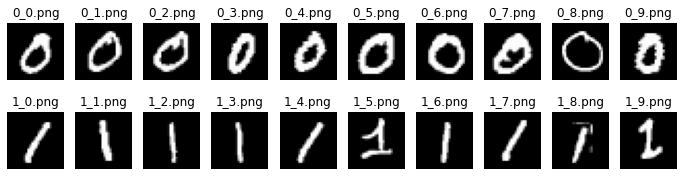

In [3]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')
numberOf_im = zeros_im.shape[0]

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    

In [4]:
# function to plot multiple images
def plotMultipleImages(nrows, ncols, images, titles, cmap, figsize_x=14, figsize_y=7, suptitle=None):
    fig = plt.figure(figsize=(figsize_x,figsize_y))
    fig.suptitle(t=suptitle, y=0.63)
    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    for i in range(len(titles)):
        ax = fig.add_subplot(nrows, ncols, i+1)
        if cmap[i]=='rgb':
            ax.imshow(images[i])
        else:
            ax.imshow(images[i], cmap=cmap[i])
        ax.set_title(titles[i])
    plt.show()

### 1.2 Fourier descriptors (15 pts)

#### 1.2.1 Preprocessing

Input image must be segmented and boundary of the object must be found out before calculating the Fourier Descriptors. Thus, appropriate image preprocessing methods are considered. 
- A low-pass filter should be used to filter out unnecessary informations that may lead to misclassification of numbers. Here, we select the `median filter` due to its main advantages: I) Median filtering preserves sharp contours which are quite important bases in Fourier descriptors, whereas linear low-pass filtering blurs such edges. II) Median filters are very efficient for smoothing of spiky noise.
- We check the histogram distribution of input image and found it is nicely bimodal. The two peaks (intensities of 0 and 255) correspond to the background and handwritten digits, and a few pixels lie in the range between 0 and 255. We then binariz the input images with thresholding to select areas of interest of images (here the digits). Because the input images are in different histrogram ditributions, a global threholding might not be good in all cases. Here, we use `Otsu's method` which determines an optimal global threshold value from the image histogram automatically.
- After that, we use `morphological opening` to remove some white patches caused by residual noise (can be found in 1_8.png).
- Finally, function `find_countours` is used to detect the contours of objects. And the returned value is a list of the coordinates of the contour pixels in order, going **counterclocwise** around the shape.

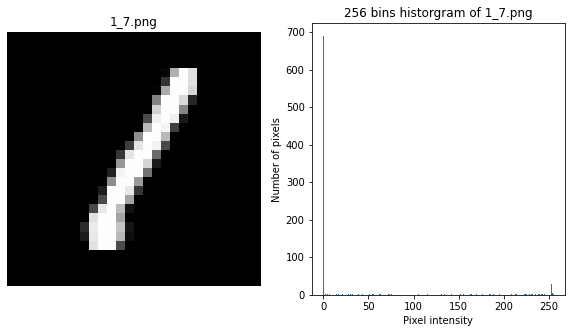

In [5]:
# test image
ind = 7
test_im = ones_im[ind]
test_im_name = ones_names[ind]

# check the histrogram ditribution
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_im, cmap='gray')
ax[0].set_title(test_im_name)
ax[0].axis('off') 
ax[1].hist(test_im.ravel(), bins=256) 
ax[1].set_title('256 bins historgram of '+test_im_name)
ax[1].set_xlabel('Pixel intensity')
ax[1].set_ylabel('Number of pixels')
plt.show()

In [6]:
def get_ordered_contour(in_im):
    # a list of the coordinates of the contour pixels (float type)
    
    contours = measure.find_contours(in_im, 5)
    ordered_contour = []
    contour_im = np.zeros(in_im.shape).astype(np.uint8)
    contour_len = []
    for contour in contours:
        contour_len.append(contour.shape[0])
        contour = np.rint(contour).astype(np.uint8)
        for x,y in contour:
            ordered_contour.append((x,y))
            contour_im[x,y] = 255
    #print(contour_len)
    return np.array(ordered_contour).astype(int), contour_im

def pre_processing(in_im, thresh=5):
    # De-noise
    # median filter with kernel = 1
    
    median_im = cv.medianBlur(in_im, 1)

    # Image binarization
    # Otsu's thresholding
    _,binary_im = cv.threshold(median_im, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)

    # Morphological opening
    morph_im = skimage.morphology.diameter_opening(binary_im,thresh)
    
    # get the orderred contours
    ordered_contour, contour_im = get_ordered_contour(morph_im)
    
    return median_im, binary_im, morph_im, contour_im, ordered_contour

def collect_contours_forAll(numberOf_im, zeros_im, ones_im, thresh=5):
    # compute the contour coordinates
    zeros_contour = []
    ones_contour = []
    zeros_contour_im = np.zeros(zeros_im.shape).astype(np.uint8)
    ones_contour_im = np.zeros(ones_im.shape).astype(np.uint8)
    for ind, zeros, ones in zip(range(numberOf_im), zeros_im, ones_im):
        _, _, _, contour_im, ordered_contour = pre_processing(zeros)
        zeros_contour_im[ind] = contour_im
        zeros_contour.append(ordered_contour)
        _, _, _, contour_im, ordered_contour = pre_processing(ones, thresh)
        ones_contour_im[ind] = contour_im
        ones_contour.append(ordered_contour)
    return zeros_contour, ones_contour, zeros_contour_im, ones_contour_im

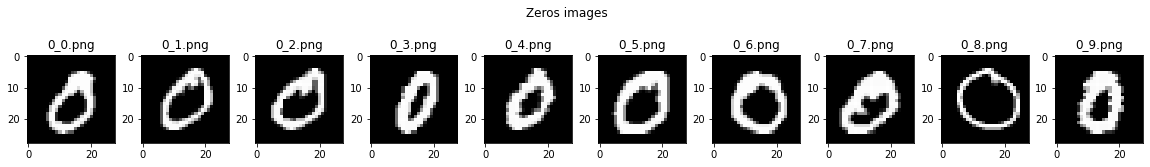

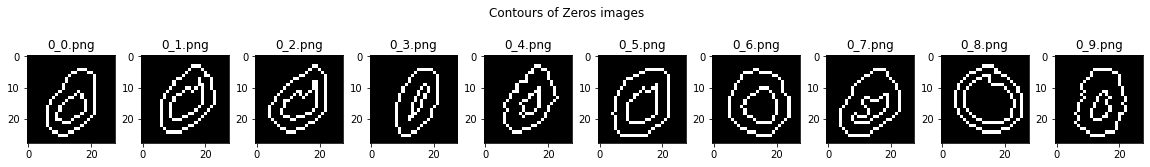

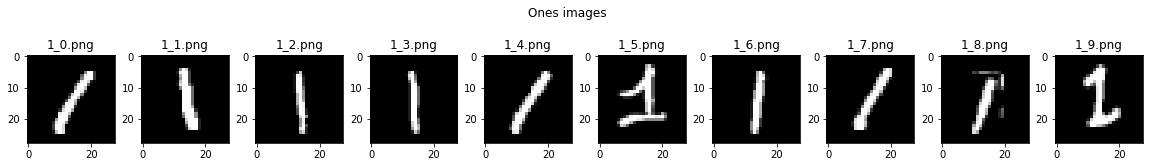

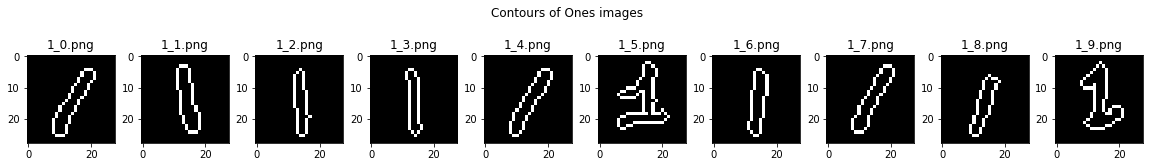

In [7]:
zeros_contour, ones_contour, zeros_contour_im, ones_contour_im = collect_contours_forAll(numberOf_im, zeros_im, ones_im)
# display the plots
plotMultipleImages(1, 10, zeros_im, zeros_names, cmap=['gray']*10, figsize_x=20, figsize_y=10,suptitle='Zeros images')
plotMultipleImages(1, 10, zeros_contour_im, zeros_names, cmap=['gray']*10, figsize_x=20, figsize_y=10, suptitle='Contours of Zeros images')
plotMultipleImages(1, 10, ones_im, ones_names, cmap=['gray']*10, figsize_x=20, figsize_y=10,suptitle='Ones images')
plotMultipleImages(1, 10, ones_contour_im, ones_names, cmap=['gray']*10, figsize_x=20, figsize_y=10, suptitle='Contours of Ones images')

#### 1.2.2 Implementation of Fourier descriptors

Fourier descriptors are a way of encoding the shape of a two-dimensional object by taking the Fourier transform of the boundary, where every  point on the boundary is mapped to a complex number. Let $(x_n, y_n)$ be the coordinates of the $n^{th}$ pixel on the contour of a given 2D shape, a complex number can be formed as: $C_n = x_n + j*y_n$. Now the Fourier Descriptors are calculated by combining complex array Fourier transform coefficients $C_0,C_1,C_2,......,C_{N-1}$. Thus, the following steps are followed:
- We firstly represent the `zeros_contour` and `ones_contour` obtained in previous part as an array of such complex numbers which corresponds to the pixels of the object if the image is placed in the complex plane.
- Then the pre-existing function `fft` in numpy is used to compute the Fourier descriptors $(F_0, F_1,...,F_{N-1})$. Users can select the first N descriptors which contain the majority of the shape information of the object as the results. 
- Because the first descriptor $F_0$ ("DC-component") of Fourier transform gives the average power of whole signal and is quite sensitive to the translation, we decided to truncate it to ensure location-invariance and select Fourier descriptors only from $F_1, F_2,...,F_{N-1}$.
- The fourier descriptors are complex here, thus we take their amplitudes as features.

In [8]:
# index of selected fourier descriptors: start, start+1, ..., start+N-1
def get_Fourier_descriptors(real_contour, start=1, N=2, scale=None):
    complex_contour = np.zeros(real_contour.shape[0], dtype=complex)
    complex_contour.real = real_contour[:,0]
    complex_contour.imag = real_contour[:,1]
    
    descriptors = np.fft.fft(complex_contour)
    
    if scale:
        features = np.abs(descriptors[start:start+N])/np.abs(descriptors[1])
    else:
        features = np.abs(descriptors[start:start+N])
        
    return features

def get_features(zeros_contour, ones_contour, start=1, N=2, scale=None):
    
    zeros_features = []
    ones_features = []
    
    for zeros, ones in zip(zeros_contour, ones_contour):
        features = get_Fourier_descriptors(zeros, start, N, scale)
        zeros_features.append(features)
        features = get_Fourier_descriptors(ones, start, N, scale)
        ones_features.append(features)
        
    return np.array(zeros_features), np.array(ones_features)

def plot_features(
    zeros_features, 
    ones_features, 
    annote=None, 
    title=None, 
    plt_ax=None,
    xlabel='Amplitude of descriptor 1',
    ylabel='Amplitude of descriptor 2',
    xlim=None,
    ylim=None,
    loc='lower right'
):
    if not plt_ax:
        plot_method= plt
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    else:
        plot_method = plt_ax
        plot_method.set_xlabel(xlabel)
        plot_method.set_ylabel(ylabel)
    
    plot_method.scatter(zeros_features[:,0], zeros_features[:,1], label='digit 0')
    plot_method.scatter(ones_features[:,0], ones_features[:,1], label='digit 1')
    if annote:
        annote_text = [str(i) for i in range(10)]
        for text, zeros, ones in zip(annote_text, zeros_features, ones_features):
            plot_method.annotate(text, (zeros[0],zeros[1]), textcoords="offset points",
                         xytext=(0,10),
                         ha='center')
            plot_method.annotate(text, (ones[0],ones[1]), textcoords="offset points",
                         xytext=(0,10), 
                         ha='center')
    if title:
        if not plt_ax:
            plt.title(title, fontweight="bold")
        else:
            plot_method.set_title(title, fontweight="bold")
    
    if xlim:
        if not plt_ax:
            plt.xlim(xlim)
            plt.ylim(ylim)
        else:
            plot_method.set_xlim(xlim)
            plot_method.set_ylim(ylim)
            
    plot_method.legend(loc=loc)

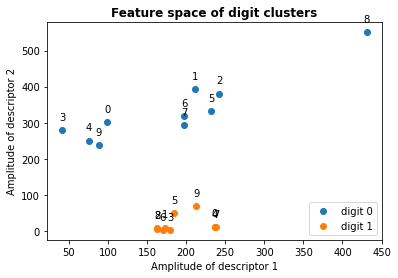

In [9]:
# take features
zeros_features, ones_features = get_features(zeros_contour, ones_contour)
plot_features(zeros_features, ones_features, annote=True, title='Feature space of digit clusters')

From the figure above, both digit clusters are well classified by using only two features of Fourier descriptors. It is possible to seperate these two clusters by using a simple linear classifier due to their high inter-variance. Additionally, the Fourier descriptors can capture the intra-variance for each cluster well. From raw images, we can see that most digit-1 objects (except for 1_5.png and 1_9.png) have similar contours, which means that the digit-1 cluster has a small intra-variance and thus it gives a compact form in feature space. For digit-0 cluster, due to the inconsistent written formats of digit-0 objects, it has a high intra-variance and thus it gives a sparse form in feature space, for example, slender 0s (i.e., 0_4.png and 0_9.png) give much lower energy in Fourier descriptors than those fat 0s (i.e., 0_5.png and 0_7.png), and 0_8.png becomes a outlier in feature space because it has much more contours than others.

#### 1.2.3 Properties of Fourier descriptor
In this section, rotation, translation and scaling are applied on raw images to check if Fourier descriptor is robust to image transformation.

##### 1.2.3.1 Rotation invariance
By Image rotation, the image is rotated about its center by specified number of degrees $(\theta)$, which can be defined by constructing a matrix in the form: $\begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$. Idealized rotation for the angle $(\theta)$ can be expressed as multiplication of the every element in the Fourer descriptors array with $e^{\theta{i}}$ . The discrete Fourier transform of such an array can be given as: $e^{\theta{i}}F_1, e^{\theta{i}}F_2,...,e^{\theta{i}}F_{N-1}$. Thus, for attaining the rotational invariance it is enough to take the absolute value of each descriptor, because $|e^{\theta{i}}| = 1$.


In [10]:
def rotate_image(raw_im, degree = 45):
    '''
        To rotate image with certain degrees. 
        Degree is positive for anti-clockwise and negative for clockwise.
        
        Input: grayscale image, rotation degrees. 
        Output: rotated grayscale image. 
    '''
    # get the dimensions of the image
    (height, width) = raw_im.shape
    # calculate the center of the image
    center = (width // 2, height // 2)
    # get a rotation mask
    mask = cv.getRotationMatrix2D(center, degree, 1.0)
    # rotate the image
    rotated_im = cv.warpAffine(src=raw_im, M=mask, dsize=(width,height))
    
    return rotated_im

Here we test 

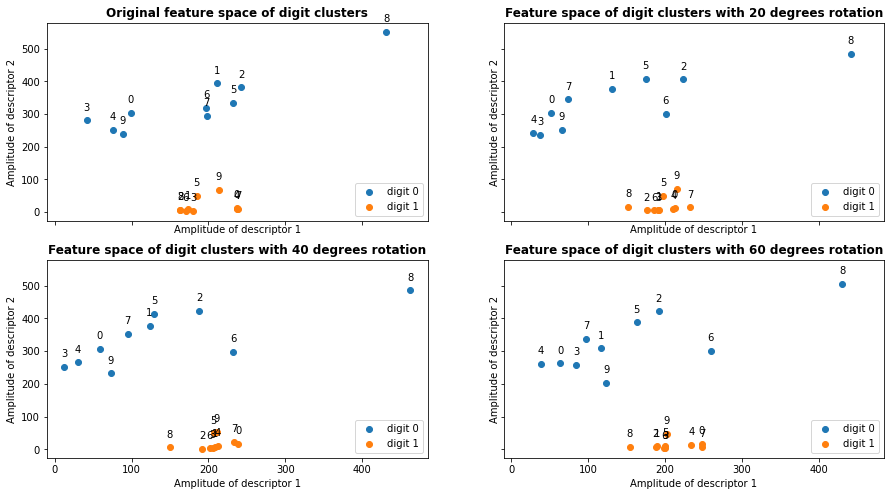

In [11]:
# test the rotate_image function on images
zeros_rotate_im = np.zeros(zeros_im.shape).astype(np.uint8)
ones_rotate_im = np.zeros(ones_im.shape).astype(np.uint8)
degrees = [20, 40, 60]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,8))
ax = axes.ravel()
zeros_features, ones_features = get_features(zeros_contour, ones_contour)
plot_features(zeros_features, ones_features, annote=True, title='Original feature space of digit clusters', plt_ax=ax[0])
for i, degree in enumerate(degrees):
    for ind, zeros, ones in zip(range(numberOf_im), zeros_im, ones_im):
        zeros_rotate_im[ind] = rotate_image(zeros, degree)
        ones_rotate_im[ind] = rotate_image(ones, degree)
    zeros_rotate_contour, ones_rotate_contour, _ , _ = collect_contours_forAll(numberOf_im, zeros_rotate_im, ones_rotate_im)
    zeros_rotate_features, ones_rotate_features = get_features(zeros_rotate_contour, ones_rotate_contour)
    plot_features(zeros_rotate_features, ones_rotate_features, annote=True, title='Feature space of digit clusters with {0} degrees rotation'.format(degree), plt_ax=ax[i+1])

Since we use the absolute values of the Fourier descriptors, rotation invariance is already present. Rotation of the contour is simply a phase shift, which does not factor into the absolute value. In order to demonstrate this, the images are rotated by random degrees and their fourier descriptors are displayed again.

##### 1.2.3.2 Translation invariance
Translation refers to the rectilinear shift of an object i.s. an image from one location to another. If we know the amount of shift in horizontal and the vertical direction, say $(t_x, t_y)$ then we make a transformation matrix e.g. $\begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{bmatrix}$. According to the theory [1], the translation affects only the value of discrete Fourier transform’s first element, and the translation invariance can be acquired just by truncating the first element $F_0$. Thus, we use 

In [12]:
def translate_image(raw_im, tx, ty):
    '''
        To translate image with distances tx, ty. 
        
        Input: grayscale image, translation distance. 
        Output: translated grayscale image. 
    '''
    # get the dimensions of the image
    (height, width) = raw_im.shape
    # get a translation mask
    mask = np.float32([[1, 0, tx], [0, 1, ty]])
    # translate the image
    translate_im = cv.warpAffine(src=raw_im, M=mask, dsize=(width,height))
    
    return translate_im.astype(np.uint8)

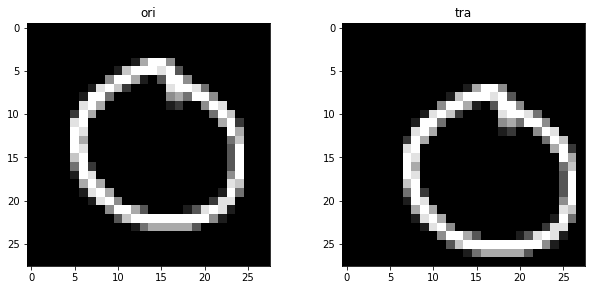

In [13]:
# test image
ind = 8
test_im = zeros_im[ind]
translate_dist = [2, 3]
test_translate_im = translate_image(test_im, translate_dist[0], translate_dist[1])
images = [test_im, test_translate_im]
title = ['ori', 'tra']
plotMultipleImages(1, 2, images, title, cmap=['gray']*2, figsize_x=10, figsize_y=7)

Here we use conservative translation distances because a significant translation might cause parts of image objects to be cropped/hidden (i.e. out of scene) which will definitely change the Fourier descriptors.

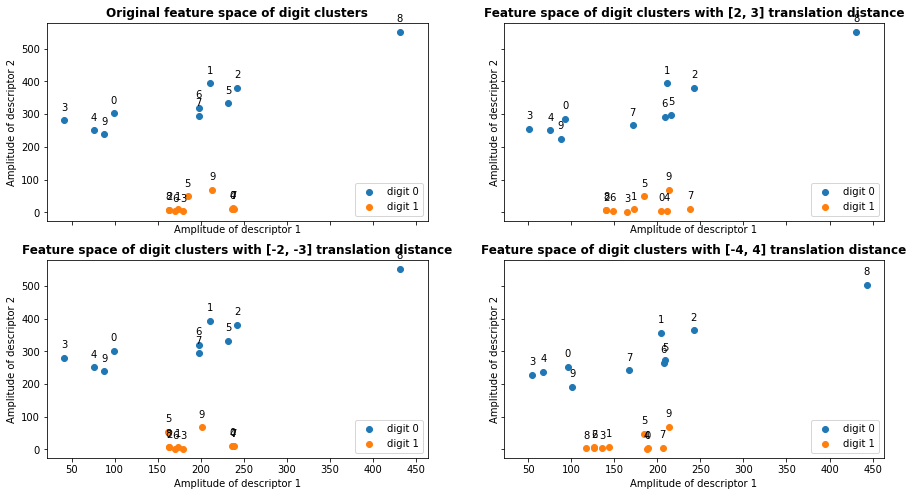

In [14]:
# test the translate_image function on images
zeros_translate_im = np.zeros(zeros_im.shape).astype(np.uint8)
ones_translate_im = np.zeros(ones_im.shape).astype(np.uint8)
translate_dists = [[2, 3], [-2, -3], [-4, 4]]
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,8))
ax = axes.ravel()
zeros_features, ones_features = get_features(zeros_contour, ones_contour)
plot_features(zeros_features, ones_features, annote=True, title='Original feature space of digit clusters', plt_ax=ax[0])
for i, translate_dist in enumerate(translate_dists):
    for ind, zeros, ones in zip(range(numberOf_im), zeros_im, ones_im):
        zeros_translate_im[ind] = translate_image(zeros, translate_dist[0], translate_dist[1])
        ones_translate_im[ind] = translate_image(ones, translate_dist[0], translate_dist[1])
    zeros_translate_contour, ones_translate_contour, _ , _ = collect_contours_forAll(numberOf_im, zeros_translate_im, ones_translate_im)
    zeros_translate_features, ones_translate_features = get_features(zeros_translate_contour, ones_translate_contour)
    plot_features(zeros_translate_features, ones_translate_features, annote=True, title='Feature space of digit clusters with {0} translation distance'.format(translate_dist), plt_ax=ax[i+1])

##### 1.2.3.3 Scaling invariance
Rescaling an image means changing the dimensions of it, be it width alone, height alone or changing both of them. Here we use `rescale` function from skimage library to resize an image by a given scaling factor. Idealized scaling can be expressed as multiplication of the every element in the array with the real constant $C$

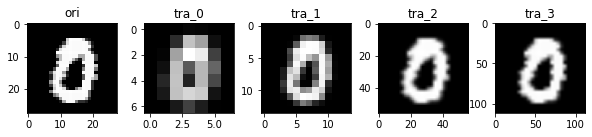

[6. 6.] (7, 7) (14, 14) (56, 56) (112, 112)


In [15]:
# test image
ind = 9
test_im = zeros_im[ind]
scale_factors = [0.25, 0.5, 2, 4]
test_scale_im_0 = (rescale(test_im, scale_factors[0], preserve_range=True, anti_aliasing=True))
test_scale_im_1 = (rescale(test_im, scale_factors[1], preserve_range=True, anti_aliasing=True))
test_scale_im_2 = (rescale(test_im, scale_factors[2], preserve_range=True)).astype(np.uint8)
test_scale_im_3 = (rescale(test_im, scale_factors[3], preserve_range=True)).astype(np.uint8)
images = [test_im, test_scale_im_0, test_scale_im_1, test_scale_im_2, test_scale_im_3]
title = ['ori', 'tra_0', 'tra_1', 'tra_2', 'tra_3']
plotMultipleImages(1, 5, images, title, cmap=['gray']*5, figsize_x=10, figsize_y=7)
print(np.round(np.dot(test_im.shape,0.2)), test_scale_im_0.shape, test_scale_im_1.shape, test_scale_im_2.shape, test_scale_im_3.shape)


factor is  1
factor is  0.5
factor is  2
factor is  4


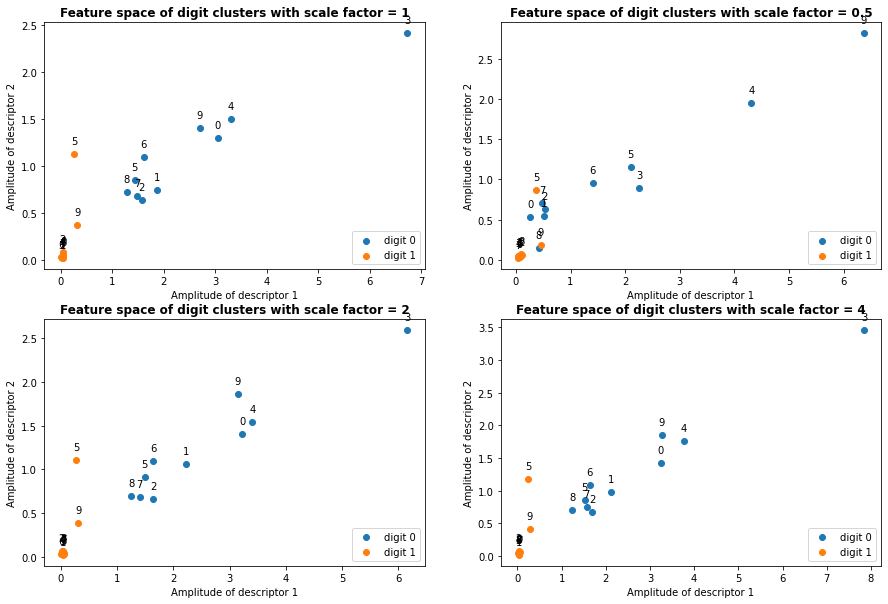

In [16]:
scale_factors = [1, 0.5, 2, 4]
threshs = [5, 5, 10, 20]
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15,10))
ax = axes.ravel()
#zeros_features, ones_features = get_features(zeros_contour, ones_contour, start=2, N=2, scale=True)
#plot_features(zeros_features, ones_features, annote=True, title='Original feature space of digit clusters', plt_ax=ax[0])
for i, scale_factor in enumerate(scale_factors):
    print('factor is ',scale_factor)
    scale_shape = (10, int(28*scale_factor), int(28*scale_factor))
    zeros_scale_im = np.zeros(scale_shape).astype(np.uint8)
    ones_scale_im = np.zeros(scale_shape).astype(np.uint8)
    for ind, zeros, ones in zip(range(numberOf_im), zeros_im, ones_im):
        zeros_scale_im[ind] = rescale(zeros, scale_factor, preserve_range=True, anti_aliasing=False)
        ones_scale_im[ind] = rescale(ones, scale_factor, preserve_range=True, anti_aliasing=False)
    zeros_scale_contour, ones_scale_contour, _ , _ = collect_contours_forAll(numberOf_im, zeros_scale_im, ones_scale_im, thresh=threshs[i])
    zeros_scale_features, ones_scale_features = get_features(zeros_scale_contour, ones_scale_contour, start=2, N=2, scale=True)
    plot_features(zeros_scale_features, ones_scale_features, annote=True, title='Feature space of digit clusters with scale factor = {0}'.format(scale_factor), plt_ax=ax[i])

#### 1.2.4 Discussion on using Fourier descriptors (TODO)

### 1.3 Additional method (5 pts)

#### 1.3.1 Ideas

Different features are extracted for digits separation, which are list as follows

1. area of the digit $S$
2. perimeter of the digit $P$
3. the filled area of digits after computing contours $S_f$
4. ratio of filled area to perimeter $S_f/P$
5. distribution historgram of the pixels from the center of mass
    1. calculate the center of mass (CoM) of the digits.
    2. calculate the rotated angle and main axis by finding minimal rotated enclosing rectangle or ellipse with `cv2.minAreaRect` or `cv2.fitEllipse`.
    3. divide the 360 degrees into $x$ bins ($x$ is set as 12, i.e., 30 degrees is the bin size) and put the digit pixel into different bins by calculating angle between main axis and CoM to pixel.
    4. calculate the standard deviation of normalized histogram (as shown in **Fig 1.3.2** and **1.3.3**).

#### 1.3.2 Utility function

In [17]:
from skimage.measure import find_contours
from skimage import img_as_float, img_as_bool
# from scipy import ndimage as ndi
# ndi.center_of_mass
# ndi.binary_fill_holes
# find_contours: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours

In [18]:
# Add your implementation and discussion
def compute_area(binary_img, background=0):
    bool_img = img_as_bool(binary_img)
    return np.sum(bool_img != background)

def compute_perimeter(binary_img, compute_all = True):
    bool_img = img_as_bool(binary_img) # use bool or not
    contours = find_contours(bool_img, 0.8)
    # todo: discuss feature
    if compute_all:
        contour_len = np.sum([len(cnt) for cnt in contours])
    else:
        # Select the largest contiguous contour
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_len = len(contour)
    return contour_len

def compute_filled_area(binary_img, background=0):
    bool_img = img_as_bool(copy.deepcopy(binary_img))
    contours = find_contours(bool_img, 0.8)
    # print("Detected contours: ",len(contours))
    contour = sorted(contours, key=lambda x: len(x))[-1]
    filled_img = np.zeros_like(bool_img, dtype='bool')
    filled_img[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
    filled_img = ndi.binary_fill_holes(filled_img)
    origin_area = compute_area(binary_img, background=0)
    filled_area = np.sum(filled_img != background)
    if filled_area < origin_area:
        filled_area = origin_area
    return filled_area

# ndi.center_of_mass(bool_test_im)
def compute_com(binary_img, background=0):
    bool_img = img_as_bool(binary_img)
    return np.round(np.mean(np.argwhere(bool_img==1),axis=0)).astype('int')

def compute_rotate_angles(binary_img, use_ellipse=True):
    bool_img = img_as_bool(binary_img)
    img_array = Image.fromarray(np.uint8(bool_img*255))
    cv_image = np.array(img_array) 
    _, thresh = cv2.threshold(cv_image, 127, 255, 0)
    contours, _ = cv2.findContours(thresh, 1, 2)
    cnt = contours[0]
    cnt = cv2.convexHull(cnt)
    # print("Rectangle axis angle:", rect[2])
    if use_ellipse and cnt.shape[0]>=5:
        ellipse = cv2.fitEllipse(cnt)
        angle_rot = ellipse[-1]
        if angle_rot < 90:
            angle_rot = angle_rot
        else:
            angle_rot = angle_rot - 180
        # ellipse_im = cv2.ellipse(binary_im, ellipse,(0,255,0),2)
        # print("Ellipse axis angle from vertical:", angle_trans)
    else:
        rect = cv2.minAreaRect(cnt)
        # box = cv2.boxPoints(rect)
        # box = np.int0(box)
        # print("Not stable -> Not implemented!")
        angle_rot = rect[-1]
        p = np.array(rect[1])
        if p[0] < p[1]:
            act_angle = angle_rot + 180
        else:
            act_angle = angle_rot + 90
        if act_angle < 90:
            angle_rot = 90 + angle_rot
        else:
            angle_rot = act_angle - 180
    return angle_rot

def img_cor_trans(image_cor, x_max=28):
    return [image_cor[1], x_max-image_cor[0]-1]

# bins = 18
# print(np.linspace(0, 360, bins+1).astype('int'))
# bin_size = 20
# print(np.arange(0, 360+bin_size, bin_size))
def compute_dist_hist(binary_img, bin_num=12, use_ellipse=True):
    # calculate rotated angles
    angle_trans = compute_rotate_angles(binary_img, use_ellipse)
    
    ## calculate histogram 
    # make as bool
    bool_img = img_as_bool(binary_img)
    # compute center of mass
    com = compute_com(bool_img)
    # print('Center of mass:', com)
    trans_com = img_cor_trans(com)
    # print(trans_com)
    pixels = np.argwhere(bool_img==1)
    # calculate degrees for each pixels
    degrees = []
    for pixel in pixels:
        trans_pixel = img_cor_trans(pixel)
        y = trans_pixel[1] - trans_com[1]
        x = trans_pixel[0] - trans_com[0]
        ang = np.arctan2(y, x) * 180 / np.pi
        corr_ang = angle_trans + ang
        if corr_ang < 0:
            corr_ang += 360
        degrees.append(corr_ang)
    hist, bin_edges = np.histogram(degrees, bins=np.linspace(0, 360, bin_num+1).astype('int'))
    return hist, bin_edges

# ref: https://stackoverflow.com/a/52976715
def viz_deg_dist(hist, bin_edges, ax=None, new_fig=False):
    # degrees = np.random.randint(0, 360, size=200)
    # radians = np.deg2rad(degrees)
    bin_size = 360 / len(hist)
    centers = np.deg2rad(np.ediff1d(bin_edges)//2 + bin_edges[:-1])

    if new_fig:
        fig = plt.figure(figsize=(10,8))
        ax = fig.add_subplot(111, projection='polar')
    ax.bar(centers, hist, width=np.deg2rad(bin_size), bottom=0.0, color='.8', edgecolor='k')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    if new_fig:
        plt.show()
    
def compute_hist_std(hist):
    hist_nor = [ele/sum(hist) for ele in hist]
    hist_std = np.std(hist_nor)
    # TODO: use top2 bin dominance ...
    return hist_std

In [19]:
def compute_feats(imgs):
    feat = {
        'area': [],
        'filled_area': [],
        'perimeter': [],
        'filled2peri': [],
        'hist_std': [],
                 }

    for idx, img in enumerate(imgs):
        im_area = compute_area(img)
        im_filled_area = compute_filled_area(img)
        im_perimeter = compute_perimeter(img)
        hist, bin_edges = compute_dist_hist(img, bin_num=12)
        im_hist_std = compute_hist_std(hist)
        feat['area'].append(im_area)
        feat['filled_area'].append(im_filled_area)
        feat['perimeter'].append(im_perimeter)
        feat['filled2peri'].append(im_filled_area/im_perimeter)
        feat['hist_std'].append(im_hist_std)
    return feat

#### 1.3.3 Examples

**Fig 1.3.1 Comparison of original image, and its binary and filled format**

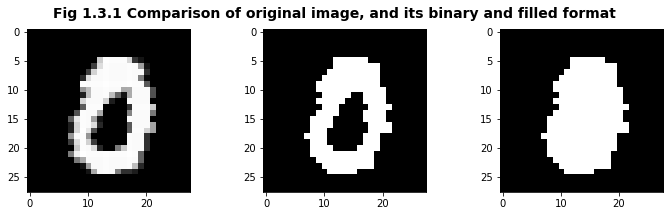

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
# 1 - test_im
axes[0].imshow(test_im, cmap='gray')

# 2 - bool_test_im
bool_test_im = img_as_bool(test_im)
axes[1].imshow(bool_test_im, cmap='gray')

# 3 - filled_test_im
contour = find_contours(bool_test_im, 0.8)
filled_test_im = np.zeros_like(bool_test_im, dtype='bool')
# Create a contour image by using the contour coordinates rounded to their nearest integer value
filled_test_im[np.round(contour[0][:, 0]).astype('int'), np.round(contour[0][:, 1]).astype('int')] = 1
filled_test_im = ndi.binary_fill_holes(filled_test_im)
axes[2].imshow(filled_test_im, cmap='gray')

plt.suptitle(
    "Fig 1.3.1 Comparison of original image, and its binary and filled format",
    fontweight='bold', size=14
)
plt.show()

In [21]:
print('Area:', compute_area(test_im))
print('Filled area:', compute_filled_area(test_im))
print('Perimeter:', compute_perimeter(test_im))
print('Center of mass:', compute_com(test_im))
print('Center of mass:', compute_com(test_translate_im))

Area: 168
Filled area: 216
Perimeter: 114
Center of mass: [14 14]
Center of mass: [17 16]


**Fig 1.3.2 Digit 0 example and its correspoding pixel distribution**

Area: 171
Filled area: 270
Perimeter: 124
Center of mass: [14 14]
Ellipse axis angle from vertical: 41.34846115112305
Std of Histogram: 0.02340703695618485


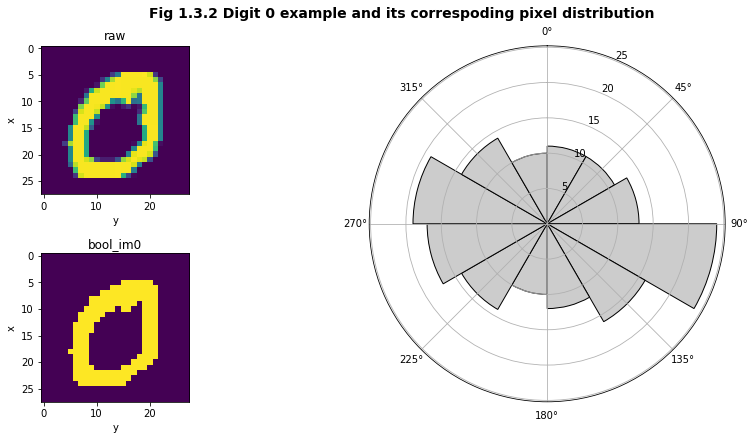

In [22]:
im0 = zeros_im[5]
print('Area:', compute_area(im0))
print('Filled area:', compute_filled_area(im0))
print('Perimeter:', compute_perimeter(im0))
print('Center of mass:', compute_com(im0))

bool_im0 = img_as_bool(im0)
im0_array = Image.fromarray(np.uint8(bool_im0*255))
cv_image = np.array(im0_array) 

## calculate angles to obtain hist
angle_ell = compute_rotate_angles(im0, use_ellipse=True)
print("Ellipse axis angle from vertical:", angle_ell)
hist, bin_edges = compute_dist_hist(im0)
print('Std of Histogram:', compute_hist_std(hist))

## viz
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
spec = fig.add_gridspec(2, 3)

ax00 = fig.add_subplot(spec[0, 0])
ax00.imshow(im0)
ax00.set_title('raw')
ax00.set_xlabel('y')
ax00.set_ylabel('x')

ax01 = fig.add_subplot(spec[1, 0])
ax01.imshow(bool_im0)
ax01.set_title('bool_im0')
ax01.set_xlabel('y')
ax01.set_ylabel('x')

ax1 = fig.add_subplot(spec[:, 1:], projection='polar')
viz_deg_dist(hist, bin_edges, ax=ax1)

plt.suptitle(
    "Fig 1.3.2 Digit 0 example and its correspoding pixel distribution",
    fontweight='bold', size=14
)
plt.show()

**Fig 1.3.3 Digit 1 example and its correspoding pixel distribution**

Area: 66
Filled area: 66
Perimeter: 65
Center of mass: [15 14]
Ellipse axis angle from vertical: 29.863548278808594
Std of Histogram: 0.10097853041985963


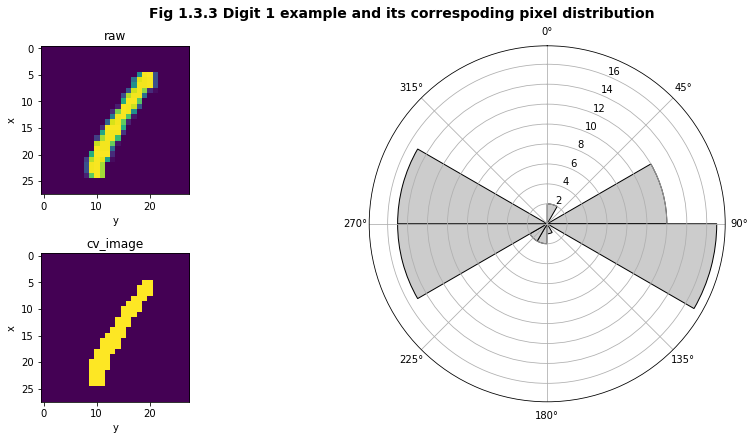

In [23]:
# ref
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html
# https://github.com/rtharungowda/hcg/blob/2cc3125e120d3279bfe8daf89e16f28d38ac4767/segmentation.py
im1 = ones_im[0]

print('Area:', compute_area(im1))
print('Filled area:', compute_filled_area(im1))
print('Perimeter:', compute_perimeter(im1))
print('Center of mass:', compute_com(im1))

bool_im1 = img_as_bool(im1)
im1_array = Image.fromarray(np.uint8(bool_im1*255))
cv_image = np.array(im1_array) 

## calculate angles to obtain hist
angle_ell = compute_rotate_angles(im1, use_ellipse=True)
print("Ellipse axis angle from vertical:", angle_ell)
hist, bin_edges = compute_dist_hist(im1)
print('Std of Histogram:', compute_hist_std(hist))

## viz
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
spec = fig.add_gridspec(2, 3)

ax00 = fig.add_subplot(spec[0, 0])
ax00.imshow(im1)
ax00.set_title('raw')
ax00.set_xlabel('y')
ax00.set_ylabel('x')

ax01 = fig.add_subplot(spec[1, 0])
ax01.imshow(cv_image)
ax01.set_title('cv_image')
ax01.set_xlabel('y')
ax01.set_ylabel('x')

ax1 = fig.add_subplot(spec[:, 1:], projection='polar')
viz_deg_dist(hist, bin_edges, ax=ax1)

plt.suptitle(
    "Fig 1.3.3 Digit 1 example and its correspoding pixel distribution",
    fontweight='bold', size=14
)
plt.show()

#### 1.3.4 Extract features to cluster digits

##### 1.3.4.1 Performance on original images

In [24]:
feat0_ori = compute_feats(zeros_im)
feat1_ori = compute_feats(ones_im)
feat0_ori 

{'area': [132, 125, 133, 139, 150, 171, 170, 181, 101, 168],
 'filled_area': [200, 220, 224, 173, 191, 270, 275, 247, 301, 216],
 'perimeter': [112, 126, 130, 104, 114, 124, 126, 130, 150, 114],
 'filled2peri': [1.7857142857142858,
  1.746031746031746,
  1.7230769230769232,
  1.6634615384615385,
  1.6754385964912282,
  2.1774193548387095,
  2.1825396825396823,
  1.9,
  2.006666666666667,
  1.894736842105263],
 'hist_std': [0.038004840765889926,
  0.032407132273964356,
  0.03727411959332292,
  0.040426526780535293,
  0.03448026810929533,
  0.02340703695618485,
  0.013116753098293774,
  0.03605004715626787,
  0.013071765278675623,
  0.02501888931134621]}

**Fig 1.3.4 Feature space of digit clusters by using digit area and perimeter**

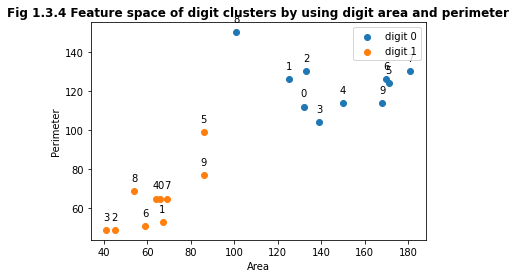

In [25]:
zeros_feats = np.array([feat0_ori['area'], feat0_ori['perimeter']]).T
ones_feats = np.array([feat1_ori['area'], feat1_ori['perimeter']]).T
plot_features(zeros_feats, 
              ones_feats, 
              annote=True, 
              loc='upper right',
              title='Fig 1.3.4 Feature space of digit clusters by using digit area and perimeter',
              xlabel='Area',
              ylabel='Perimeter'
             )

**Fig 1.3.5 Feature space of digit clusters by using composed features**

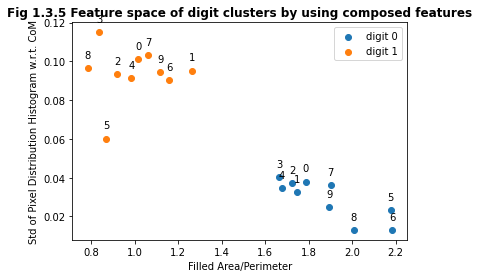

In [26]:
zeros_feats = np.array([feat0_ori['filled2peri'], feat0_ori['hist_std']]).T
ones_feats = np.array([feat1_ori['filled2peri'], feat1_ori['hist_std']]).T
plot_features(zeros_feats, 
              ones_feats, 
              annote=True, 
              loc='upper right',
              title='Fig 1.3.5 Feature space of digit clusters by using composed features',
              xlabel='Filled Area/Perimeter',
              ylabel='Std of Pixel Distribution Histogram w.r.t. CoM'
             )

##### 1.3.4.2 Invariant performance to different transformation

In [27]:
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')

zeros_rotate_im = np.zeros(zeros_im.shape).astype(np.uint8)
ones_rotate_im = np.zeros(ones_im.shape).astype(np.uint8)
degree = 60

zeros_translate_im = np.zeros(zeros_im.shape).astype(np.uint8)
ones_translate_im = np.zeros(ones_im.shape).astype(np.uint8)
translate_dist = [2, -3]

# TODO: possible ValueError: could not broadcast input array from shape (56,56) into shape (14,14)
scale_factor = 0.5
scale_shape = (10, int(28*scale_factor), int(28*scale_factor))
zeros_scale_im = np.zeros(scale_shape).astype(np.uint8)
ones_scale_im = np.zeros(scale_shape).astype(np.uint8)

In [28]:
for ind, zeros, ones in zip(range(numberOf_im), zeros_im, ones_im):
    zero_process = copy.deepcopy(zeros)
    one_process = copy.deepcopy(ones)
    
    zeros_rotate_im[ind] = rotate_image(zero_process, degree)
    ones_rotate_im[ind] = rotate_image(one_process, degree)
    
    zeros_translate_im[ind] = translate_image(zero_process, translate_dist[0], translate_dist[1])
    ones_translate_im[ind] = translate_image(one_process, translate_dist[0], translate_dist[1])
    
    zeros_scale_im[ind] = rescale(zero_process, scale_factor, preserve_range=True, anti_aliasing=False)
    ones_scale_im[ind] = rescale(one_process, scale_factor, preserve_range=True, anti_aliasing=False)

**Fig 1.3.6 Example of different transformation on the digits**

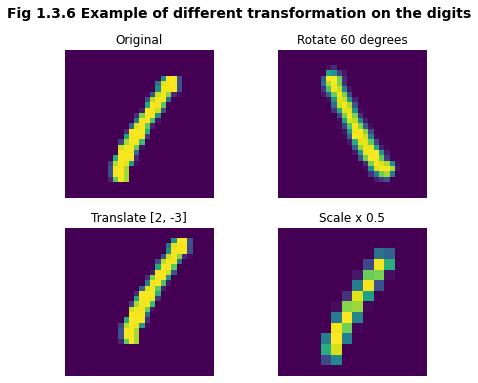

In [29]:
fig_invar, axes_invar = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7,6))
ax_invar = axes_invar.ravel()

ax_invar[0].imshow(ones_im[0])
ax_invar[0].set_title("Original")
ax_invar[0].axis('off')
ax_invar[1].imshow(ones_rotate_im[0])
ax_invar[1].set_title("Rotate 60 degrees")
ax_invar[1].axis('off')
ax_invar[2].imshow(ones_translate_im[0])
ax_invar[2].set_title("Translate [2, -3]")
ax_invar[2].axis('off')
ax_invar[3].imshow(ones_scale_im[0])
ax_invar[3].set_title("Scale x 0.5")
ax_invar[3].axis('off')

plt.suptitle(
    "Fig 1.3.6 Example of different transformation on the digits",
    fontweight='bold', size=14
)
plt.show()

**Fig 1.3.7 Clustering results under different transformation**

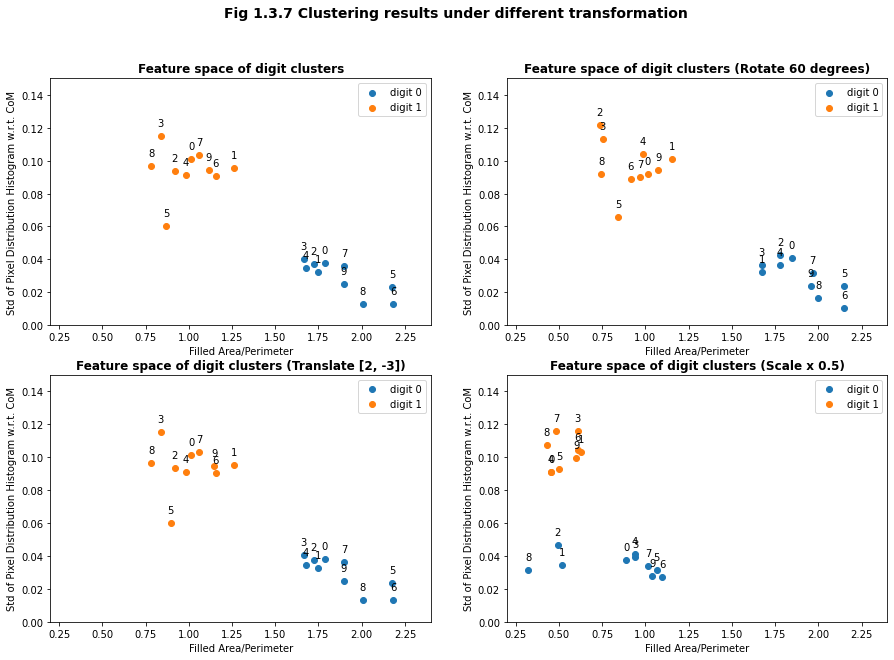

In [30]:
title_append = [
    '',
    ' (Rotate 60 degrees)',
    ' (Translate [2, -3])', 
    ' (Scale x 0.5)', 
]

fig_new, axes_new = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(15,10))
ax_new_ = axes_new.ravel()

for idx, (zeros_im, ones_im) in enumerate([
    (zeros_im, ones_im),
    (zeros_rotate_im, ones_rotate_im),
    (zeros_translate_im, ones_translate_im),
    (zeros_scale_im, ones_scale_im),
]):
    if idx == 0:
        feat0 = feat0_ori
        feat1 = feat1_ori
    else:
        feat0 = compute_feats(zeros_im)
        feat1 = compute_feats(ones_im)
    zeros_feats = np.array([feat0['filled2peri'], feat0['hist_std']]).T
    ones_feats = np.array([feat1['filled2peri'], feat1['hist_std']]).T
    plot_features(zeros_feats, 
                  ones_feats, 
                  annote=True, 
                  title='Feature space of digit clusters'+title_append[idx],
                  loc='upper right',
                  xlabel='Filled Area/Perimeter',
                  ylabel='Std of Pixel Distribution Histogram w.r.t. CoM',
                  plt_ax = ax_new_[idx],
                  xlim=[0.2, 2.4],
                  ylim=[0.0, 0.15],
                 )
plt.suptitle(
    "Fig 1.3.7 Clustering results under different transformation",
    fontweight='bold', size=14
)
plt.show()

#### 1.3.5 Discussion on using different methods

1. As shown in Fig 1.3.4, simple parameter, such as area and perimeter can separate the two classes, but it can be easily influenced by outliers.
2. As shown in Fig 1.3.5, Calculating the filled area removed the outlier problem and comparing the filled area with perimeter can improve clusterization. 
3. Fig 1.3.7 shows composed features such as Filled Area/Perimeter, and standard deviation of pixel distribution are mostly robust to bounded translation and rotation, but only is more standard deviation of pixel distribution against scaling.
3. Possible failure cases may happen when translate outside the range, resulting inconsistent pixels compare to original image.


---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

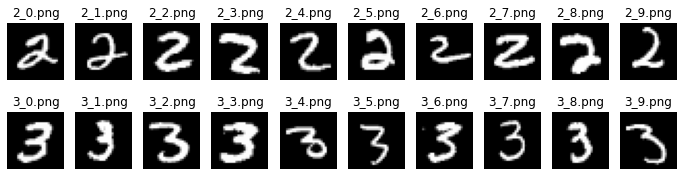

In [31]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [32]:
# Add your implementation and discussion